# Случайность в вероятности и на практике

О подходах к понятию случайности: 

Н.К. Верещагин, В.А. Успенский, А. Шень. Колмогоровская сложность и алгоритмическая случайность. 
https://www.mccme.ru/free-books/shen/kolmbook.pdf

А.Н. Ширяев. Случайность в вероятности (доклад на семинаре кафедры теории веротяностей). http://www.mathnet.ru:8080/PresentFiles/21897/bsk_2018_10_17_shiryaev_an_randomness_in_probability_slides.pdf

## Генераторы случайных чисел

Что происходит при вызове, напрмер, ```np.random.rand()```?

Как устроен источник случайной последовательности?

![img](https://cdn.ablebits.com/_img-blog/random-generator/random-generator.png)

Рассмотрим простой и популрный алгоритм - Linear congruential generator (LCG). При вызове функции ```rand()``` в C/C++ происзодит обращение именно к LCG.

Linear congruential generator производит последовательность:
$$ z_{i+1} = (az_i + c) \mod m $$

Число $z_0$ называется *seed* и обеспечивает воспроизводимость последовательности “случайных” чисел.

Напишем функцию, которая реализует LCG:

In [9]:
def rng(m=2**32, a=1103515245, c=12345):
    rng.current = (a * rng.current + c) % m
    return rng.current / m

# setting the seed
rng.current = 1

Выведем несколько первых элементов последовательности:

In [10]:
[rng() for i in range(10)]

[0.25693503906950355,
 0.5878706516232342,
 0.15432575810700655,
 0.767266943352297,
 0.9738139626570046,
 0.5858681506942958,
 0.8511155843734741,
 0.6132153405342251,
 0.7473867232911289,
 0.06236015981994569]

Выбор параметров $m$, $a$ и $c$ существенно влияет на качество последовательности. Если параметры выбрать наобум, это может привести к неожиданным последствиям:

In [11]:
def rng(m=97, a=5, c=0):
    rng.current = (a * rng.current + c) % m
    return rng.current / m
rng.current = 7

random = [rng() for i in range(1000)]
print("This sequence looks as random:")
random[:10]

This sequence looks as random:


[0.36082474226804123,
 0.8041237113402062,
 0.020618556701030927,
 0.10309278350515463,
 0.5154639175257731,
 0.5773195876288659,
 0.8865979381443299,
 0.4329896907216495,
 0.16494845360824742,
 0.8247422680412371]

Гистограмма распределения похожа на равномерное:

In [12]:
import matplotlib.pyplot as plt
plt.hist(random, density=True)
plt.show()

<Figure size 640x480 with 1 Axes>

Однако, спектральный тест показывает, что точки располагаются на гиперплоскостях, что плохо согласуется с предствалением о случайности:

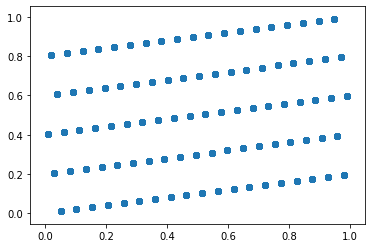

In [13]:
plt.scatter(random[1:], random[:-1])
plt.show()

Более аккуратный выбор параметров приводит с более "случайному" распределению:

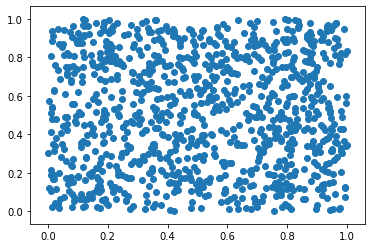

In [14]:
def rng(m=2**32, a=1103515245, c=12345):
    rng.current = (a * rng.current + c) % m
    return rng.current / m
rng.current = 1

random = [rng() for i in range(1000)]
plt.scatter(random[1:], random[:-1])
plt.show()

Существует набор тестов для проверки "случайности". Например, тесты [Diehard tests](https://en.wikipedia.org/wiki/Diehard_tests).

Больше методов генерации собрано [здесь](https://en.wikipedia.org/wiki/List_of_random_number_generators).

## Генерация выборки из заданного распределения

Допустим, у нас есть генератор случайных числе из отрезка [0, 1]. Как получить выборку из нового распределения $F$?



### Задача
Смоделировать выборку объема 1000 из дискретного распределения на множестве цифр 0, 1, 2, ..., 9 с весами 0.12, 0.3, 0.167, 0.24, 0.31, 0.54, 0.111, 0.02, 0.001, 0.2. По выборке построить гистограмму. Оптимизируйте алгоритм, упорядочив веса. Сравните время генерации выборки с неупорядоченными и упорядоченными весами.

[ 61. 137.  83. 124. 166. 278.  54.  10.   1.  86.]


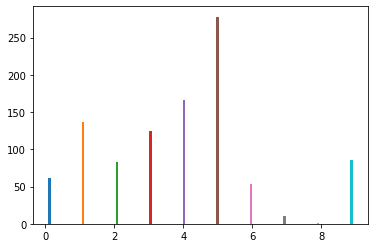

In [15]:
import numpy as np

random = [rng() for i in range(1000)]
#arr = [0 for i in range(0, 10)]
arr = np.zeros(10)
mas = np.array([0.12, 0.3, 0.167, 0.24, 0.31, 0.54, 0.111, 0.02, 0.001, 0.2])
np.sort(mas)[::-1]
mas = mas/mas.sum()
for i in range (1, 10):
    mas[i] = mas[i] + mas[i-1]
for i in range (1000):
    for j in range (10):
        if ((j == 0 and random[i] < mas[j]) or (random[i] < mas[j] and random[i] >= mas[j-1])):
            arr[j] = arr[j] + 1
            break
    
print(arr)
a = np.array([[i]*int(arr[i]) for i in range(10)])
plt.hist(a)
plt.show()

## Если отсортировать весы по убыванию, то генерация пройдет быстрее, так как вероятность попасть в самый большой отрезок самая большая и цикл в среднем будет работать меньше

### Inverse transform method

В следующем предложении заключается идея метода *inverse transform*:

Если $\xi$ имеет равномерное распределение в $[0,1]$, тогда $F^{-1}(\xi)$ распределена по закону $F$. (Для каких $F$ это верно?)

### Задача
Смделируйте выборку размера 1000 из распределения $Exp(\lambda)$. Постройте выборочную гистограмму и точный график плотности распределения.

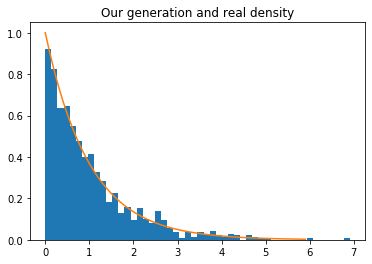

In [16]:
#Функция распределения 1 - е^(-lx) = u
#Обратная функция x = -ln(1-u)/l
#Будем считать что лямбда равна 1 и сравним результат с библиотечной функцией
#Для данного метода подойдет строго возрастающая функция распределения, чтобы обратная находилась однозначно
from math import log
import scipy.stats

def inv(u, l):
    return -log(1-u)/l

random = [rng() for i in range(1000)]
random = [inv(random[i], 1) for i in range(1000)]
plt.title("Our generation and real density")
plt.hist(random, density=True, bins = 50)

r = np.arange(0, 6, .1)
plt.plot(r, scipy.stats.expon.pdf(r, scale=1))
plt.show()

### Rejection sampling (Accept-reject method)

Идея метода: сэмплить из распределения, из которого умеем, а затем отбирать точки, которые следуют нужному распределению. Картинка иллюстрирует идею метода:
<img src=https://colcarroll.github.io/hamiltonian_monte_carlo_talk/images/bayes_talk.015.png style="width: 50%;"/>
 

### Задача
Обоснуйте, что метод accept-reject действительно производит выборку из нужного распределения. Смоделируйте 1000 точек из усеченного распределения Коши, приведенного ниже, используя генератор равномерного распределения. Нарисуйте график полученной выборочной гистограммы и сравните его с графиком точной функции плотности.

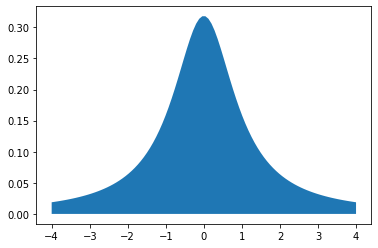

In [17]:
from scipy import stats
import numpy as np
dist = stats.cauchy()
x = np.linspace(-4, 4, 100)
plt.fill_between(x, 0, dist.pdf(x)) #needs to be normalized!
plt.show()

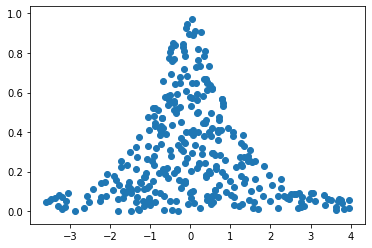

In [18]:
needed = np.array([[x[i] for i in range(100)], [dist.pdf(x)[i] for i in range (100)]])
random = np.array([[(rng()-0.5)*8 for i in range(1000)], [rng() for i in range(1000)]])

needed[1] = needed[1]/needed[1].max()
for i in range (1000):
    for j in range (100):
            if (needed[0][j-1] <= random[0][i] and needed[0][j] >= random[0][i]):
                if(j > 50):
                    if (random[1][i] > needed[1][j-1]): random[0][i] = 0
                else:
                    if (random[1][i] > needed[1][j]): random[0][i] = 0
                break;
            
answ = np.array([[random[0][random[0] != 0]], [random[1][random[0] != 0]] ])
#random = random[random != 0]
#print(random[1].max())
plt.scatter(answ[0], answ[1])
plt.show()

##  Coordinate transformation method

Метод аccept-reject в ряде случаев может оказываться неэффективным и требовать слишком много пробных точек. Альтернатива -  попробовать найти преобразование координат, которое переводит простую область (из которой легко сэмплить, например, едининчный квадрат) в требуемую, но при этом сохраняет соотношение площадей.

### Задача
Смоделировать выборку из 500 точек равномерно распределенных внутри данного треугольника без использования метода отбора. 

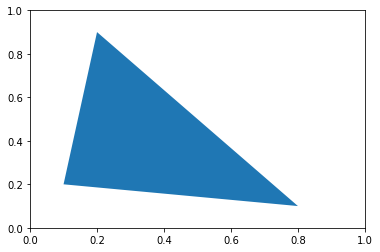

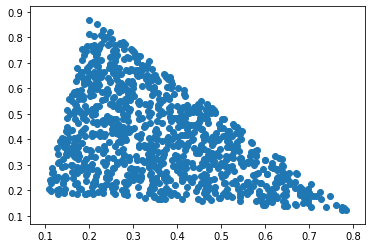

In [19]:
import matplotlib
from matplotlib.patches import Polygon
from matplotlib.collections import PatchCollection

polygon = Polygon(0.1 * np.array([[1, 2], [2, 9], [8, 1]]), True)
plt.gca().add_collection(PatchCollection([polygon]))
plt.show()


x = np.array([rng() for i in range(1000)])
y = np.array([rng() for i in range(1000)])
x[(x + y) > 1] = 1 - x[(x + y) > 1]
y[(x + y) > 1] = 1 - y[(x + y) > 1] #хотим брать только нужны точки из нашего квадрата

x =  0.7 * x + 0.1 * y + 0.1
y = -0.1 * x + 0.7 * y + 0.2 #ортогональное движение

plt.scatter(x, y)
plt.show()

### Задача
Смоделировать выборку из 500 точек внутри данного круга без использования метода отбора.

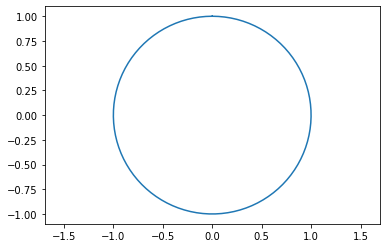

In [20]:
from matplotlib.patches import Circle
t = np.linspace(0, 2 * np.pi, 100)
plt.plot(np.sin(t), np.cos(t))
plt.axis('equal')
plt.show()

(-2.714466801225406,
 2.7434255564925127,
 -2.763365230674148,
 2.7306078715442723)

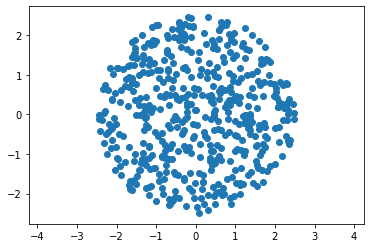

In [21]:
angle = np.array([rng()*2*np.pi for i in range(500)])
r = [rng()*2*np.pi for i in range(500)]

#Посчитаем вероятность попадения в круг радиусa t : pi*t^2/pi = t^2 - функция распределения F_{R}(t) = t^2
#Тогда чтобы получить распределением радиуса из нормального достаточно просто найти обратную: sqrt(U)
plt.scatter(np.sqrt(r) * np.cos(angle), np.sqrt(r) * np.sin(angle))
plt.axis('equal')

### Задача
Напишите функцию, которая моделирует случайное симметричное блуждание на двумерной решетке длины n c началом и концом в точке (0, 0). Приведите графики выборочных траекторий для n=100.

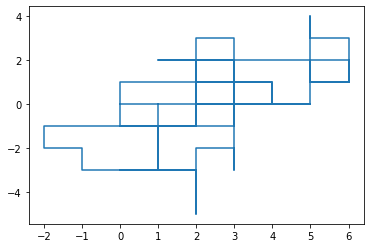

In [22]:
def rand_walking():
    x = np.array([(rng()-0.5)*2 for i in range(500)]) 

    y = np.where(x > 0)
    y = y[0][0:50]
    z = np.where(x < 0)
    z = z[0][0:50]

    ar1 = np.zeros(150)
    ar1[y] += 1

    ar2 = np.zeros(150)
    ar2[z] += 1

    ar11 = ar1[(ar1 != 0) | (ar2 != 0)]
    ar22 = ar2[(ar1 != 0) | (ar2 != 0)]

    return np.cumsum(ar11 - ar22)
###
x_1 = rand_walking()
x_2 = rand_walking()
###
#Осталось повернуть на 90 градусов так как мы рассматривали шаги 1 и -1 как движение вверх или вниз
plt.plot((x_1 + x_2) / 2, (x_1 - x_2) / 2)

## Random normal generator

### Задача
Докажите, что приведенный ниже алгоритм (Box-Muller algorithm) формирует выборку из независимых N(0,1) случаных величин. Модифицируйте метод, чтобы исключить вызовы тригонометрических функций ```np.sin``` и ```np.cos```. С помощью модивицированного метода смоделируйте выборку объема 1000 из двумерного гауссовского распределения со средним (3, 6) и ковариационной матрицей ((2, 1), (1, 4)). Постройте 2D гистограмму полученного распределения.

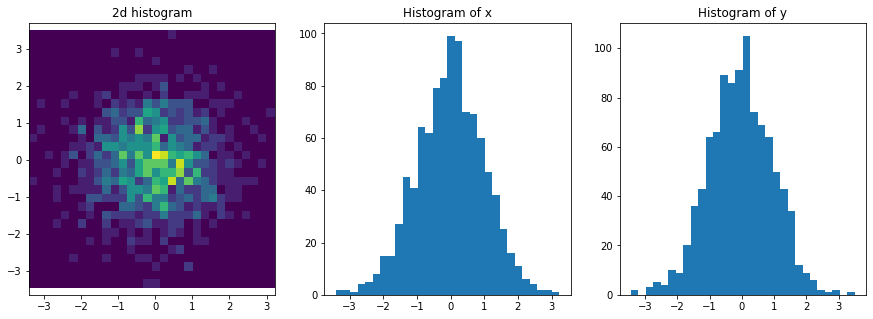

In [23]:
n = 1000
u1, u2 = np.random.rand(2, n)
r = np.sqrt(-2 * np.log(u1))
theta = 2 * np.pi * u2
x = r * np.cos(theta)
y = r * np.sin(theta)
fig, ax = plt.subplots(1, 3, figsize=(15, 5))
ax[0].hist2d(x, y, bins=30)
ax[0].axis('equal')
ax[1].hist(x, bins=30)
ax[2].hist(y, bins=30)
ax[0].set_title("2d histogram")
ax[1].set_title("Histogram of x")
ax[2].set_title("Histogram of y")
plt.show()

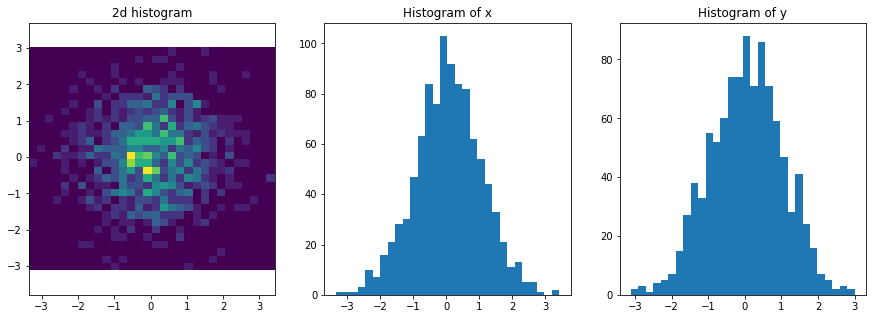

In [92]:
i = 0
cos = np.array([])
sin = np.array([])
while i<1000:
    u, v = 2*np.random.rand(2,1)-1
    s = u**2+v**2
    if 0<s<=1:
        cos = np.append(cos, u)
        sin = np.append(sin, v)
        i+=1

s = cos**2+sin**2
r = np.sqrt(-2 * np.log(s)/s)
x = cos * r
y = sin * r
fig, ax = plt.subplots(1, 3, figsize=(15, 5))
ax[0].hist2d(x, y, bins=30)
ax[0].axis('equal')
ax[1].hist(x, bins=30)
ax[2].hist(y, bins=30)
ax[0].set_title("2d histogram")
ax[1].set_title("Histogram of x")
ax[2].set_title("Histogram of y")
plt.show()

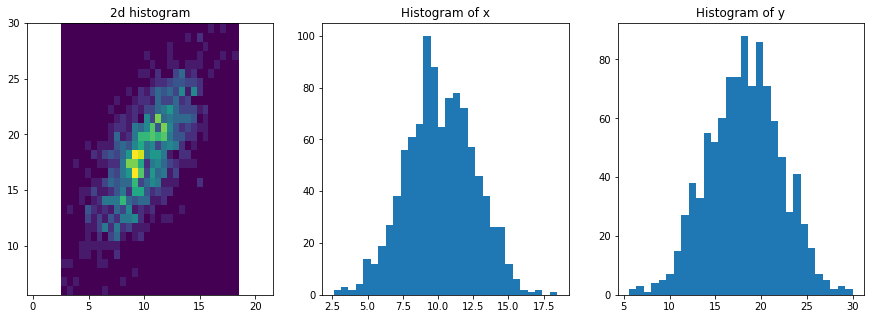

In [95]:
#Сведем задачу к предыдущей. Найдем линейную замену где данных случайных величин. Так как в многомерном
#гауссовском распределении матрица ковариционная матрица выглядит как АТА^t, то замена линейная выглядит как
#cov(x, y) = AtA. Найдем линейную замену, и найдем матрицу A. Итак, (Х У) = А(х у)
X = np.sqrt(7) / 2 * x + 1 / 2 * y + 3
Y = 2 * y + 6

fig, ax = plt.subplots(1, 3, figsize=(15, 5))
ax[0].hist2d(X, Y, bins=30)
ax[0].axis('equal')
ax[1].hist(X, bins=30)
ax[2].hist(Y, bins=30)
ax[0].set_title("2d histogram")
ax[1].set_title("Histogram of x")
ax[2].set_title("Histogram of y")
plt.show()

### Практическое задание

Реализовать метод генерации случайного разбиения n-элементного множества на подмножества. С его помощью оценить ожидаемое число подмножеств в случайном разбиении множества из 100 элементов. 

Подсказка 1: Ширяев, Вероятность, т1, задача 2 к параграфу 1.

Подсказка 2: http://djalil.chafai.net/blog/2012/05/03/generating-uniform-random-partitions/

In [81]:
def partition(n):
    b = 0
    summ = 0
    answ = []
    for k in range(100):
        b+=(k+1)**n/np.math.factorial(k+1)
    b*=1/np.exp(1)
    p = np.array([(k+1)**n/(b*np.math.factorial(k+1)*np.exp(1)) for k in range(100)])
    ar1 = np.cumsum(p)
    r = np.random.rand()
    while 1:
        if r<ar1[summ]:
            r = summ+1
            break;
        else:
            summ+=1
    
    p = np.array([1/r for i in range(r)])
    ar1 = np.cumsum(p)
    ar2 = np.array([rng() for i in range(n)])
    for i in range(n):
        summ=0
        while summ!=-1:
            if ar1[summ]>ar2[i]:
                answ.append(summ)
                summ=-1
            else:
                summ+=1
    return answ

In [88]:
#ЗБЧ
estimate = 0
for i in range(1000):
    answ = partition(100)
    estimate+=len(np.unique(answ))
print(estimate/1000)

28.569
